# Example 1 Message Graphs

In [19]:
from langchain_core.messages import HumanMessage
from langgraph.graph import MessageGraph, START, END

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from IPython.display import Image, display

In [14]:
def rotate_positions(pos, angle):
    """ Rotate positions by a given angle in degrees. """
    angle = np.radians(angle)  # Convert degrees to radians
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], 
                                [np.sin(angle), np.cos(angle)]])
    
    return {node: tuple(np.dot(rotation_matrix, coords)) for node, coords in pos.items()}


## Example Message graph

In [15]:
def funcA(input):
    input[0].content += "Agent takes action A; "
    return input

def funcB(input):
    input[0].content += "Agent takes action B; "
    return input

# Build the graph
graph = (
    MessageGraph()
    .add_node("nodeA", funcA)
    .add_node("nodeB", funcB)
    .add_edge(START, "nodeA")
    .add_edge("nodeA", "nodeB")
    .add_edge("nodeB", END)
)

runnable = graph.compile()

# Invoke the graph
result = runnable.invoke([HumanMessage(content="Input; ")])
print(result)

[HumanMessage(content='Input; Agent takes action A; Agent takes action B; ', additional_kwargs={}, response_metadata={}, id='1bc17370-2847-49c4-b1f1-a573db9b1f9f')]


# Conditional Graph Edges

In [16]:
from langchain_core.messages import HumanMessage
from langgraph.graph import MessageGraph, START, END

def fun_buy(input):
    input[0].content += " ==> Agent will buy stocks"
    return input

def fun_sell(input):
    input[0].content += " ==> Agent will sell stocks"
    return input

def fun_decision(input):
    last = input[0].content
    is_market_down = "SP500" in last and "down" in last
    return "actionBuyStocks" if is_market_down else "actionSellStocks"

# Build the graph
graph = (
    MessageGraph()
    .add_node("decision", fun_decision)
    .add_node("actionBuyStocks", fun_buy)
    .add_node("actionSellStocks", fun_sell)
    .add_edge(START, "decision")
    .add_conditional_edges("decision", fun_decision, ["actionBuyStocks", "actionSellStocks"])
    .add_edge("actionBuyStocks", END)
    .add_edge("actionSellStocks", END)
)

runnable = graph.compile()

# Invoke the graph
result = runnable.invoke([HumanMessage(content="Latest news SP500 is down to 5000")])
print(result)

[HumanMessage(content='Latest news SP500 is down to 5000 ==> Agent will buy stocks', additional_kwargs={}, response_metadata={}, id='100d7d71-c818-4167-a5f2-f5c97d0fce2b'), HumanMessage(content='actionBuyStocks', additional_kwargs={}, response_metadata={}, id='ca2b8376-832d-4472-aa7f-e529d9297fd5')]


## Cycles

In [17]:
from langchain_core.messages import HumanMessage
from langgraph.graph import MessageGraph, START, END
import random

def fun_agent(input):
    return input

def fun_use_dice_tool(input):
    dice = 1 + random.randint(0, 5)
    content = f"Dice rolled: {dice}" if dice != 6 else "objective_achieved"
    input.append(HumanMessage(content=content))
    return input

def should_continue(input):
    return "end" if input.pop().content == "objective_achieved" else "useDiceTool"

# Build the graph
graph = (
    MessageGraph()
    .add_node("agent", fun_agent)
    .add_node("useDiceTool", fun_use_dice_tool)
    .add_edge(START, "agent")
    .add_edge("useDiceTool", "agent")
    .add_conditional_edges(
        "agent", 
        should_continue, 
        {"useDiceTool": "useDiceTool", "end": END}
    )
)

runnable = graph.compile()

# Invoke the graph
result = runnable.invoke([HumanMessage(content="Start game")])
print(result)

[HumanMessage(content='Start game', additional_kwargs={}, response_metadata={}, id='7a8cc791-528f-4141-b5dc-b43470d98563'), HumanMessage(content='objective_achieved', additional_kwargs={}, response_metadata={}, id='a694436f-b800-4dfc-b6bc-ecafb19a7dbd')]


## Visualize Graphs

<Figure size 800x600 with 0 Axes>

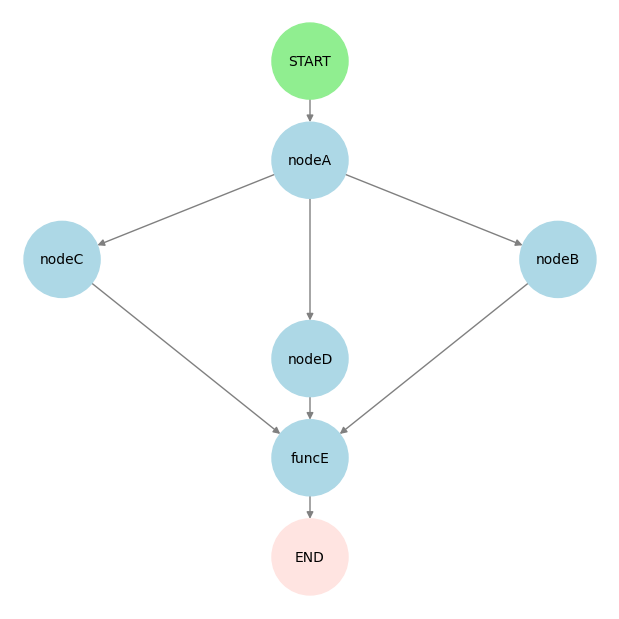

In [22]:
def funcA(input):
    input[0].content += "A"
    return input

def funcB(input):
    input[0].content += "B"
    return input

def funcC(input):
    input[0].content += "C"
    return input

def funcD(input):
    input[0].content += "D"
    return input

def funcE(input):
    input[0].content += "E"
    return input

# Build the graph
workflow = (
    MessageGraph()
    .add_node("nodeA", funcA)
    .add_node("nodeB", funcB)
    .add_node("nodeC", funcC)
    .add_node("nodeD", funcD)
    .add_node("funcE", funcE)
    .add_edge(START, "nodeA")
    .add_edge("nodeA", "nodeB")
    .add_edge("nodeA", "nodeC")
    .add_edge("nodeA", "nodeD")
    .add_edge("nodeB", "funcE")
    .add_edge("nodeC", "funcE")
    .add_edge("nodeD", "funcE")
    .add_edge("funcE", END)
)

graph = workflow.compile()

pos = {
    "START": (0, 2),
    "nodeA": (1, 2),
    "nodeB": (2, 3),
    "nodeC": (2, 1),
    "nodeD": (3, 2),
    "funcE": (4, 2),
    "END": (5, 2)
}

rotated_pos = rotate_positions(pos, -90)

# Generate and show the graph structure
G = nx.DiGraph()
G.add_edges_from([
    ("START", "nodeA"), ("nodeA", "nodeB"), ("nodeA", "nodeC"), ("nodeA", "nodeD"),
    ("nodeB", "funcE"), ("nodeC", "funcE"), ("nodeD", "funcE"), ("funcE", "END")
])

plt.figure(figsize=(8, 6))

# Define node groups
start_nodes = ["START"]
end_nodes = ["END"]
interior_nodes = [node for node in G.nodes if node not in start_nodes + end_nodes]

node_colors = {node: "#90EE90" if node in start_nodes else "#FFE4E1" if node in end_nodes else "#ADD8E6" for node in pos.keys()}

# Generate and show the graph
G = nx.DiGraph()
G.add_edges_from([
    ("START", "nodeA"), ("nodeA", "nodeB"), ("nodeA", "nodeC"), ("nodeA", "nodeD"),
    ("nodeB", "funcE"), ("nodeC", "funcE"), ("nodeD", "funcE"), ("funcE", "END")
])

plt.figure(figsize=(6, 6))

# Draw full graph with color mapping
nx.draw(G, rotated_pos, with_labels=True, node_color=[node_colors[node] for node in G.nodes()], edge_color="gray", node_size=3000, font_size=10)

plt.show()

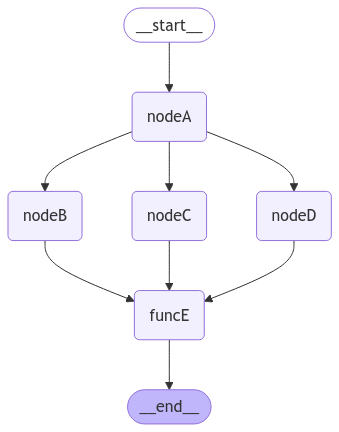

In [23]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))